# **스마트폰 센서 데이터 기반 모션 분류**

## Flow
1. 동적/정적 이진 분류 모델 구현 및 학습, 평가
2. 동적 행동의 데이터만을 이용하여 동적 행동의 다중 분류 모델 구현 및 학습, 평가
3. 정적 행동의 데이터만을 이용하여 정적 행동의 다중 분류 모델 구현 및 학습, 평가
4. 평가용 X 데이터의 입력을 1개씩 받아서 1번의 이진 분류 모델 추론 수행
5. 이진 분류 모델의 추론 값에 따라 동적/정적에 따라서 2번 또는 3번의 다중 분류 모델에 X 데이터를 입력하여 최종적으로 어떤 행동인지 추론 수행
6. 추론값과 실제값을 비교하여 Acc 계산

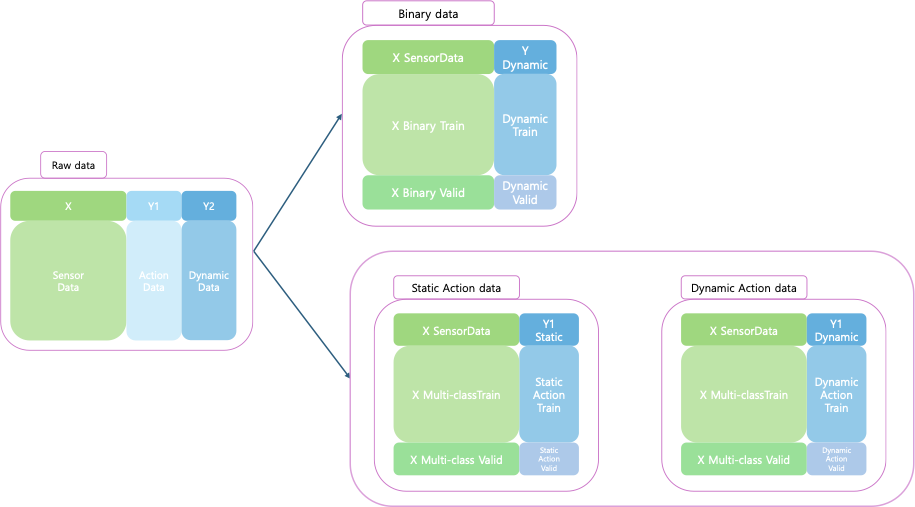

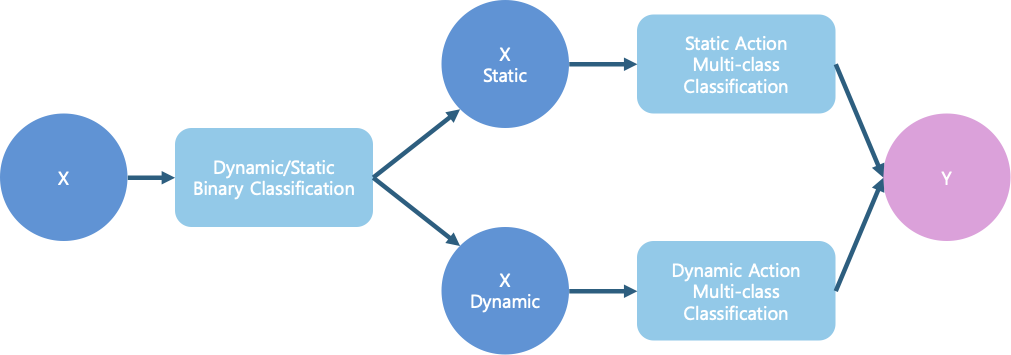

## Import Libraries

In [45]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.optimizers.legacy import Adam # MacOS
# from keras.optimizers import Adam # Windows
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.utils import plot_model

## Load Data

In [96]:
data = pd.read_csv('./data01_train.csv')
new_data = pd.read_csv('./data01_test.csv')

## Data Pre-Processing

* 동적 활동 여부 변수 추가

In [3]:
data['Activity_dynamic'] = data['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)
# new_data['Activity_dynamic'] = new_data['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)

* 동적/정적 데이터 분리

In [4]:
data_dyn = data[data['Activity_dynamic'] == 1]
data_sta = data[data['Activity_dynamic'] == 0]

* 동적/정적 이진 분류 데이터셋 분리

In [5]:
X_bi = data.drop(['Activity','Activity_dynamic'], axis=1)
y_bi = data['Activity_dynamic']

X_bi_train, X_bi_valid, y_bi_train, y_bi_valid = train_test_split(X_bi, y_bi, test_size=.3, stratify=y_bi, random_state=530)

* 동적 행동 다중 분류 데이터셋 분리

In [6]:
X_dyn = data_dyn.drop(['Activity', 'Activity_dynamic'], axis=1)
y_dyn = data_dyn['Activity']

dyn_l_enc = LabelEncoder()
y_dyn = dyn_l_enc.fit_transform(y_dyn)

X_dyn_train, X_dyn_valid, y_dyn_train, y_dyn_valid = train_test_split(X_dyn, y_dyn, test_size=.3, stratify=y_dyn,random_state=530)

* 정적 행동 다중 분류 데이터셋 분리

In [7]:
X_sta = data_sta.drop(['Activity', 'Activity_dynamic'], axis=1)
y_sta = data_sta['Activity']

sta_l_enc = LabelEncoder()
y_sta = sta_l_enc.fit_transform(y_sta)

X_sta_train, X_sta_valid, y_sta_train, y_sta_valid = train_test_split(X_sta, y_sta, test_size=.3, stratify=y_sta, random_state=530)

## Modeling - Step 1. Binary Classification

In [8]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
# 모델 정의
clear_session()
def binary_dnn(n_input):
    model = Sequential()
    model.add(Dense(256, input_dim=n_input, activation='elu'))
    model.add(Dense(128, activation='elu'))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate= 0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
   
binary_dnn_model = binary_dnn(X_bi_train.shape[1])
binary_dnn_model.summary()

Model: "sequential"


2024-03-28 09:54:56.307731: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-28 09:54:56.307749: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-28 09:54:56.307755: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-28 09:54:56.307781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-28 09:54:56.307795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               144128    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 185345 (724.00 KB)
Trainable params: 185345 (724.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


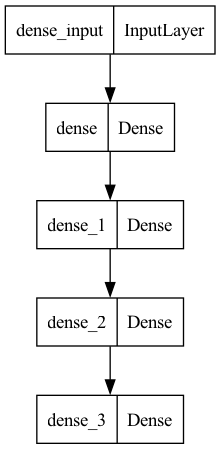

In [46]:
plot_model(binary_dnn_model)

In [10]:
es = EarlyStopping(monitor = 'val_loss', patience = 20)

binary_hist = binary_dnn_model.fit(X_bi_train, y_bi_train,
                                   epochs=150, validation_split=.2, verbose=0,
                                   callbacks = [es], batch_size=32).history

2024-03-28 09:54:56.836617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


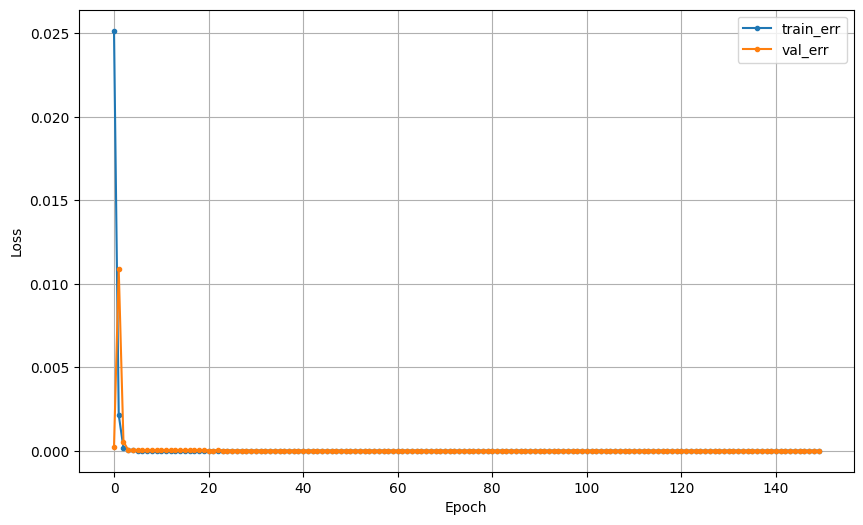

In [11]:
dl_history_plot(binary_hist)

In [12]:
binary_valid_pred = binary_dnn_model.predict(X_bi_valid)
binary_valid_pred = np.where(binary_valid_pred >= 0.5, 1, 0)
#평가
print('accuracy :',accuracy_score(y_bi_valid, binary_valid_pred))
print('='*60)
print(confusion_matrix(y_bi_valid, binary_valid_pred))
print('='*60)
print(classification_report(y_bi_valid, binary_valid_pred))

56/56 [==============================] - 0s 4ms/step
accuracy : 0.9994334277620397
[[970   1]
 [  0 794]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       971
           1       1.00      1.00      1.00       794

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



## Modeling - Step 2-1. Multi-class Classification(Static)

In [76]:
# 모델 정의
clear_session()
def static_dnn(n_input):
    model = Sequential()
    model.add(Dense(256, input_dim=n_input, activation='elu'))
    model.add(Dense(128, activation='elu'))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate= 0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
   
static_dnn_model = static_dnn(X_sta_train.shape[1])
static_dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               144128    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 185475 (724.51 KB)
Trainable params: 185475 (724.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


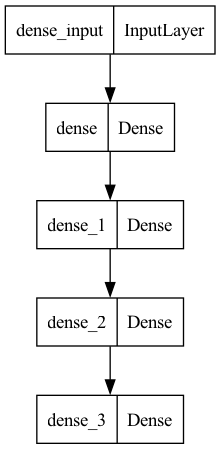

In [77]:
plot_model(static_dnn_model)

In [78]:
es = EarlyStopping(monitor = 'val_loss', patience = 30)

static_hist = static_dnn_model.fit(X_sta_train, y_sta_train,
                                   epochs=150, validation_split=.2, verbose=0,
                                   callbacks = [es], batch_size=32).history

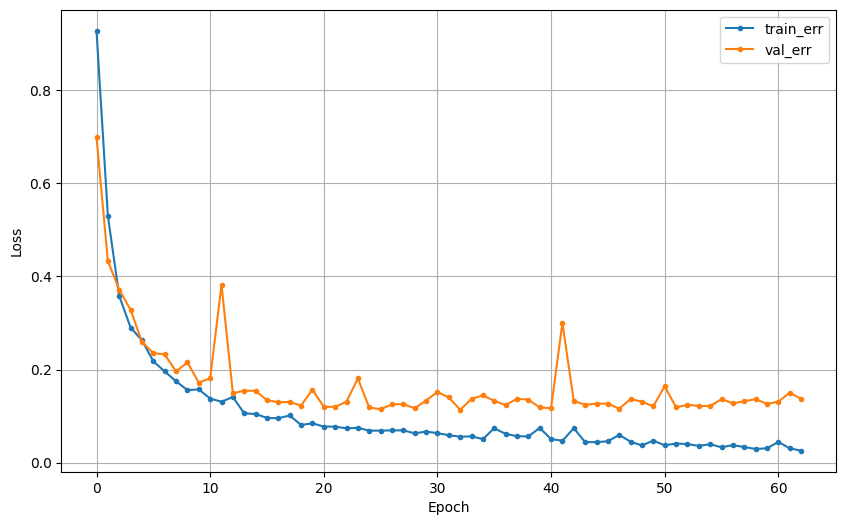

In [79]:
dl_history_plot(static_hist)

In [80]:
static_valid_pred = static_dnn_model.predict(X_sta_valid)
static_valid_pred = static_valid_pred.argmax(axis=1)

#평가
print('accuracy :',accuracy_score(y_sta_valid, static_valid_pred))
print('='*60)
print(confusion_matrix(y_sta_valid, static_valid_pred))
print('='*60)
print(classification_report(y_sta_valid, static_valid_pred))

31/31 [==============================] - 0s 4ms/step
accuracy : 0.9732234809474768
[[335   0   0]
 [  1 297  12]
 [  0  13 313]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       335
           1       0.96      0.96      0.96       310
           2       0.96      0.96      0.96       326

    accuracy                           0.97       971
   macro avg       0.97      0.97      0.97       971
weighted avg       0.97      0.97      0.97       971



## Modeling - Step 2-2. Multi-class Classification(Dynamic)

In [17]:
# 모델 정의
clear_session()
def dynamic_dnn(n_input):
    model = Sequential()
    model.add(Dense(256, input_dim=n_input, activation='elu'))
    model.add(Dense(128, activation='elu'))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate= 0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
   
dynamic_dnn_model = dynamic_dnn(X_dyn_train.shape[1])
dynamic_dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               144128    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 185475 (724.51 KB)
Trainable params: 185475 (724.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


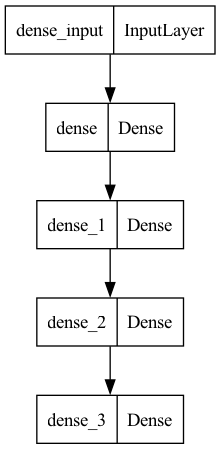

In [48]:
plot_model(dynamic_dnn_model)

In [18]:
es = EarlyStopping(monitor = 'val_loss', patience = 20)

dynamic_hist = dynamic_dnn_model.fit(X_dyn_train, y_dyn_train,
                                   epochs=150, validation_split=.2, verbose=0,
                                   callbacks = [es], batch_size=32).history

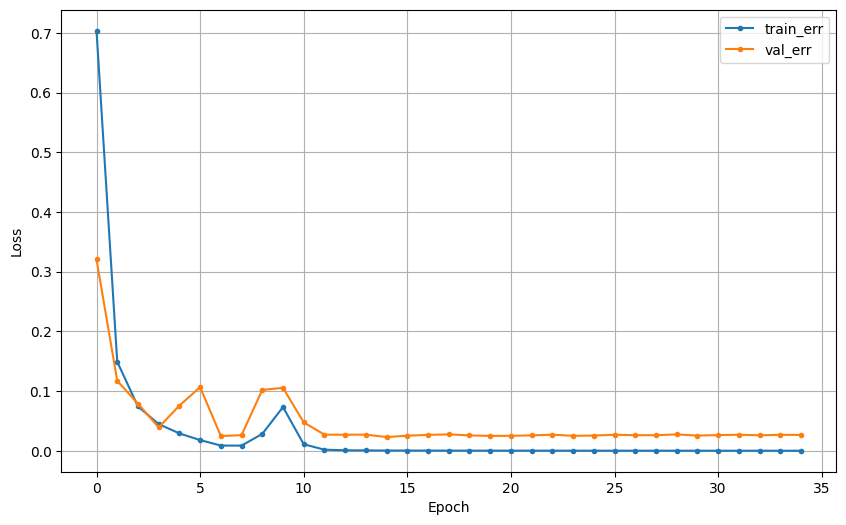

In [19]:
dl_history_plot(dynamic_hist)

In [20]:
dynamic_valid_pred = dynamic_dnn_model.predict(X_dyn_valid)
dynamic_valid_pred = dynamic_valid_pred.argmax(axis=1)

#평가
print('accuracy :',accuracy_score(y_dyn_valid, dynamic_valid_pred))
print('='*60)
print(confusion_matrix(y_dyn_valid, dynamic_valid_pred))
print('='*60)
print(classification_report(y_dyn_valid, dynamic_valid_pred))

25/25 [==============================] - 0s 5ms/step
accuracy : 0.9987421383647799
[[300   0   0]
 [  0 237   0]
 [  0   1 257]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       237
           2       1.00      1.00      1.00       258

    accuracy                           1.00       795
   macro avg       1.00      1.00      1.00       795
weighted avg       1.00      1.00      1.00       795



## Predict

In [105]:
def har_predict_pipeline(new_data, binary_model, dynamic_model, static_model):
    # 평가 데이터셋에서 X와 y분리
    X = new_data.drop('Activity',axis=1)

    y_test = new_data['Activity']
    test_l_enc = LabelEncoder()
    y_test = test_l_enc.fit_transform(y_test)
    
    # print(f"Static Label : {sta_l_enc.classes_}")
    # print(f"Dynamic Label : {dyn_l_enc.classes_}")
    # print(f"Test Label : {test_l_enc.classes_}")
    
    dynamic_pred = binary_model.predict(X) > 0.5
    final_preds = np.zeros((X.shape[0],))
    
    # 동적 행동 데이터에 대한 인덱스
    dynamic_indices = np.where(dynamic_pred.flatten() == True)[0]
    # 정적 행동 데이터에 대한 인덱스
    static_indices = np.where(dynamic_pred.flatten() == False)[0]
    
    if len(dynamic_indices) > 0:
        dynamic_activities_pred = dynamic_model.predict(X.iloc[dynamic_indices])
        dynamic_activities_pred = np.argmax(dynamic_activities_pred, axis=1)
        dynamic_activities_pred += 3  
        final_preds[dynamic_indices] = dynamic_activities_pred

    if len(static_indices) > 0:
        static_activities_pred = static_model.predict(X.iloc[static_indices])
        static_activities_pred = np.argmax(static_activities_pred, axis=1)
        final_preds[static_indices] = static_activities_pred
        
    
    # final_preds와 실제 라벨 y_test를 비교하여 정확도 계산
    accuracy = accuracy_score(y_test, final_preds)
    print(f'Accuracy: {accuracy:.4f}')
    
    # 혼동 행렬 계산
    cm = confusion_matrix(y_test, final_preds)
    class_names = test_l_enc.classes_
    # 혼동 행렬 시각화
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return final_preds

* 추론 파이프라인 수행 및 평가

27/27 [==============================] - 0s 4ms/step
Accuracy: 0.9816


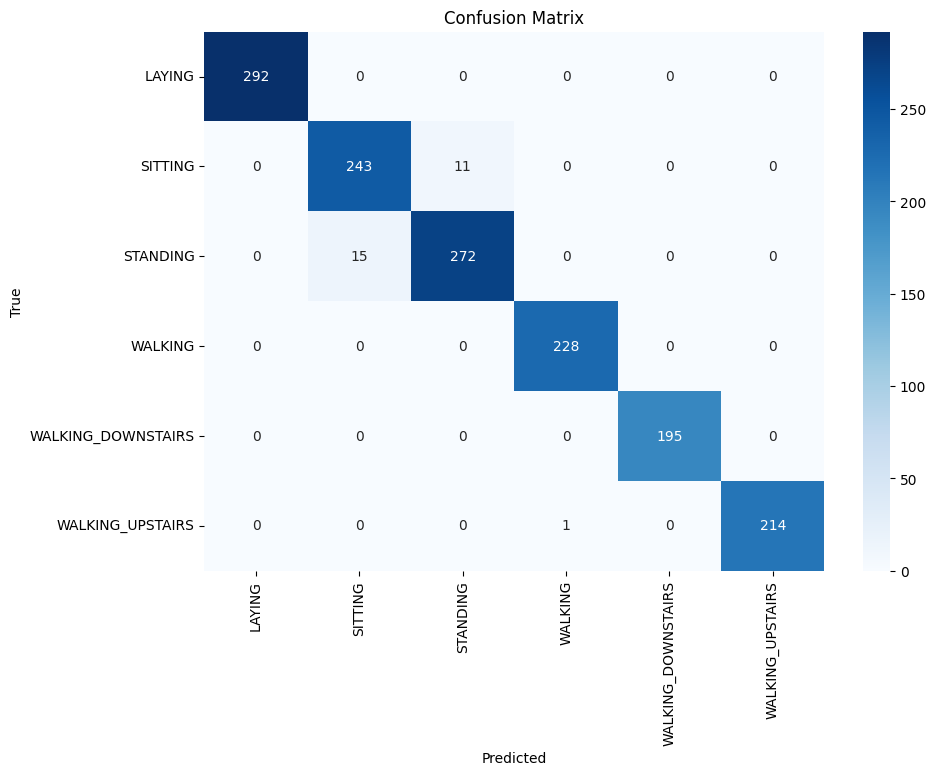

In [106]:
har_predict = har_predict_pipeline(new_data, binary_dnn_model, dynamic_dnn_model, static_dnn_model)